# Oxford5k VLAD anf Fisher Vector Retrieval Demo

This notebook demonstrates how to:
1. Load the Oxford Flower dataset.
2. Extract deep convolutional features (last conv layer) from the `vgg16` model.
3. Train a VLAD model on these deep features.
4. Perform image retrieval queries.
5. Show the effect of PCA (reducing features by half before VLAD) on retrieval performance.
6. An analogous procedure is made for Fisher Vectors

### References

[1] Relja Arandjelović and Andrew Zisserman, 'All About VLAD', Department of Engineering Science, University of Oxford. \
[2] Liangliang Wang and Deepu Rajan, "An Image Similarity Descriptor for Classification Tasks," J. Vis. Commun.
Image R., vol. 71, pp. 102847, 2020.



## 1. Imports and Setup

In [1]:
from itertools import islice

from torchvision.models import vgg16, VGG16_Weights

# Our library imports
from pyvisim.features import DeepConvFeature
from pyvisim.encoders._base_encoder import KMeansWeights, GMMWeights
from pyvisim.encoders.vlad import VLADEncoder
from pyvisim.encoders.fisher_vector import FisherVectorEncoder
from pyvisim.datasets import OxfordFlowerDataset  # We'll create this in a moment
from pyvisim._utils import *
from pyvisim.eval import retrieve_top_k_similar

### Hyperparameters

**Note**: training k-means models takes quite a bit of time. In this notebook, a single `n_clusters = 256` will be used. Add more values to `NUM_CLUSTERS` to experiment with different cluster sizes.

In [2]:
NUM_CLUSTERS = 256
IMAGE_SIZE = (224, 224)
DIM_REDUCTION_FACTOR = 2

## 2. Declare the Oxford Flower Dataset

In [3]:
train_dataset = OxfordFlowerDataset(purpose='train')
val_dataset = OxfordFlowerDataset(purpose='validation')
print("Number of images in the dataset:", len(train_dataset))

Number of images in the dataset: 6149


### Plot some images from the dataset

Image size: (500, 591, 3)


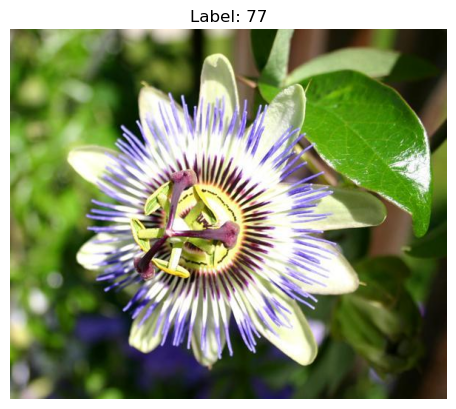

Image size: (500, 625, 3)


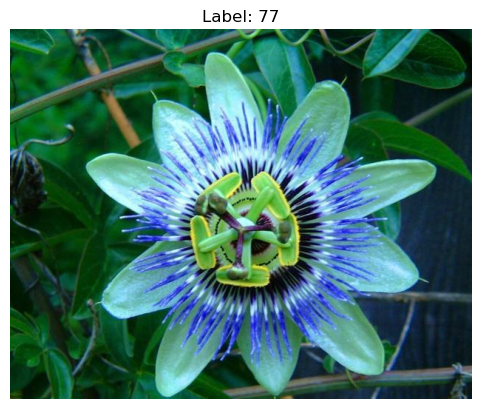

Image size: (667, 500, 3)


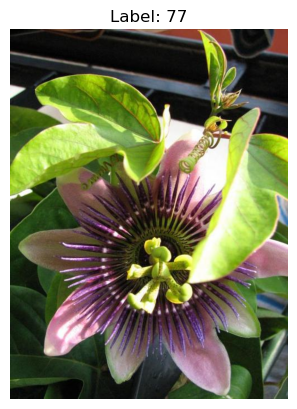

Image size: (500, 667, 3)


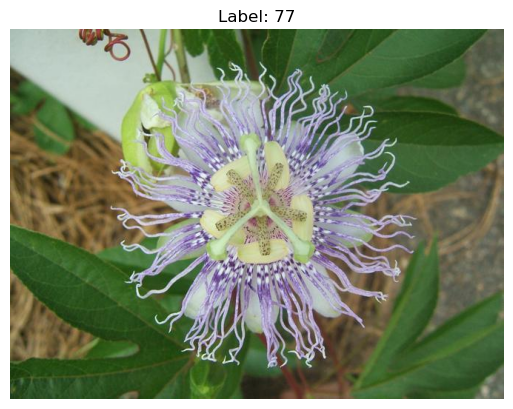

Image size: (500, 508, 3)


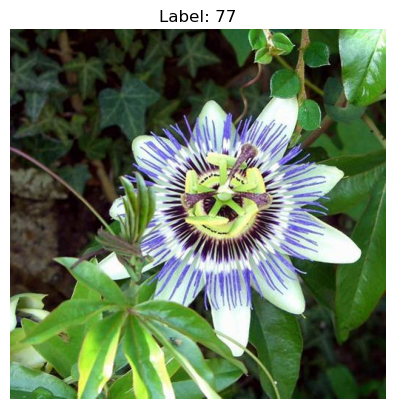

In [4]:
for i in range(5):
    img, label, _ = train_dataset[i]
    print("Image size:", img.shape)
    plot_image(img, title = f"Label: {label}")

### 3. Extract deep convolutional features

In the original paper <ref>[1]</ref>, `SIFT` and `RootSIFT` features were used. Hence, the default parameter of the encoding would be `RootSIFT`. However, here, I would like to demonstrate the usage of deep convolutional features, as mentioned in <ref>[2]</ref>.

We use `DeepConvFeatureExtractor` from our code. For demonstration, we'll pick `vgg16` and the last conv layer.


In [5]:
extractor = DeepConvFeature(
    model=vgg16(weights=VGG16_Weights.DEFAULT),
    layer_index=-1,  # Last conv layer
    spatial_encoding=True,)

2025-01-18 23:22:42,737 - Feature_Extractor - INFO - Selected layer: features.28, Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


### Declare the VLAD encoder

In [7]:
vlad_encoder_no_pca = VLADEncoder(feature_extractor=extractor, weights=KMeansWeights.OXFORD102_K256_VGG16)

You can comment out the following cell if you want to train the model from scratch, but it might take quite a bit of time.

In [15]:
# vlad_encoder_no_pca = VLADEncoder(feature_extractor=extractor)
# vlad_encoder_no_pca.learn(train_dataset, n_clusters=256)

If you have issue with the runtime, you can follow this procedure instead:
1) Train the k-means and PCA models in advance
2) Save the models using `joblib` or `pickle`. 
3) Pass the model as an argument to the `VLAD` class.

You may refer to the notebook `getting_started.ipynb` for more details.

### Generate encoding map

This generates a map `{image1_full_path: vector1, image2_full_path: vector2...}`. This method will come handy as we do image retrieval later on. for that, we first need to compute some variables from the dataset.

In [9]:
paths = [pth for *_, pth in train_dataset]

In [25]:
vlad_data = vlad_encoder_no_pca.generate_encoding_map(paths)

KeyboardInterrupt: 

Similar to above, but here, the dimension of each feature vector is reduced `by half` using `PCA`.

### Declare the VLAD encoder (with PCA)

In [8]:
vlad_encoder_with_pca = VLADEncoder(feature_extractor=extractor, weights=KMeansWeights.OXFORD102_K256_VGG16_PCA)

In [ ]:
# vlad_encoder_with_pca = VLADEncoder(feature_extractor=extractor)
# vlad_encoder_with_pca.learn(train_dataset, n_clusters=NUM_CLUSTERS, dim_reduction_factor=2)

In [ ]:
vlad_data_pca = vlad_encoder_with_pca.generate_encoding_map(paths)

## **5. Compare some images**

We will now use the trained VLAD encoders to compute similarity between some images.

In [ ]:
image_1, label_1, path_1 = train_dataset[2005]
image_2, label_2, path_2 =  val_dataset[401]
plot_image(image_1)
plot_image(image_2)

Now, we compare the two images. `cosine similarity` is used in this case.

In [ ]:
sim_with_pca = vlad_encoder_with_pca.similarity_score(image_1, image_2)
print("Similarity Score, with PCA: ", sim_with_pca)
sim_without_pca = vlad_encoder_no_pca.similarity_score(image_1, image_2)
print("Similarity Score, without PCA: ", sim_without_pca)

## **6. Fetch the most similar image in the dataset, given a query image**

Now, we will select an image in the validation dataset, on which the model is not yet trained:

In [ ]:
query_image, query_label, query_path =  val_dataset[103]

Retrieve top-k most similar images using the datasets computed. We will see how it works, with and without PCA.

In [ ]:
top_k_vlad_pca = retrieve_top_k_similar(query_image, vlad_data_pca, vlad_encoder_with_pca)
for path, score in top_k_vlad_pca:
    print(f"Path: {os.path.basename(path)}, Cosine similarity: {score:.4f}")

tok_k_vlad_no_pca = retrieve_top_k_similar(query_image, vlad_data, vlad_encoder_no_pca)
for path, score in tok_k_vlad_no_pca:
    print(f"\nPath: {os.path.basename(path)}, Cosine similarity: {score:.4f}")

### Let's plot both images next to each other.


a) Using Model trained on data with PCA

In [ ]:
plt.imshow(query_image)
plt.title(f"Query image. Label: {query_label}")
plt.show()

plt.figure(figsize=(20, 10))
for i in range(len(top_k_vlad_pca)):
    path, _ = top_k_vlad_pca[i]
    label = train_dataset.labels[train_dataset.image_paths.index(path)]
    plt.subplot(1, len(top_k_vlad_pca), i + 1)
    image = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.title(f"Retrieved image. Label: {label}")

plt.show()

b) Using model trained on full data

In [ ]:
plt.imshow(query_image)
plt.title(f"Query image. Label: {query_label}")
plt.show()

plt.figure(figsize=(20, 10))
for i in range(len(tok_k_vlad_no_pca)):
    path, _ = tok_k_vlad_no_pca[i]
    label = train_dataset.labels[train_dataset.image_paths.index(path)]
    plt.subplot(1, len(tok_k_vlad_no_pca), i + 1)
    image = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.title(f"Retrieved image. Label: {label}")

plt.show()

## **7. Similar to above, we will do the exact things for the Fisher Vector**

The implementation for both VLAD and Fisher Vectors are identical. After all, VLAD is simply a simplified case of Fisher Vector.

### Instantiate Fisher Vector Encoder

In [23]:
fisher_encoder_no_pca = FisherVectorEncoder(feature_extractor=extractor, weights=GMMWeights.OXFORD102_K256_VGG16)

514


You can comment out the following cell if you want to train the model from scratch, but it might take quite a bit of time (enev longer than VLAD).

In [ ]:
# fisher_encoder_no_pca = FisherVectorEncoder(feature_extractor=extractor)
# fisher_encoder_no_pca.learn(train_dataset)

### Generate encoding map

In [ ]:
fisher_data = fisher_encoder_no_pca.generate_encoding_map(paths)

Similar to above, if you run into memory issues, consider pre-training the model, loading them and then pass them as arguments. Simply replace the `KMeans` object with the Gaussian Mixture object, which can be imported as:

```python
from sklearn.mixture import GaussianMixture
```

Otherwise, the implementation is identical to that of `VLADEncoder`.


### Instantiate Fisher Vector Encoder with PCA

In [24]:
fisher_encoder_with_pca = FisherVectorEncoder(feature_extractor=extractor, weights=GMMWeights.OXFORD102_K256_VGG16_PCA)

In [ ]:
# fisher_encoder_with_pca = FisherVectorEncoder(feature_extractor=extractor)
# fisher_encoder_with_pca.learn(train_dataset, n_clusters=NUM_CLUSTERS, dim_reduction_factor=2)

In [ ]:
fisher_data_pca = fisher_encoder_with_pca.generate_encoding_map(paths)

### Compute similarity of two images

In [ ]:
image_similarity_with_pca = fisher_encoder_with_pca.similarity_score(image_1, image_2)
image_similarity_without_pca = fisher_encoder_no_pca.similarity_score(image_1, image_2)
print("Fisher Similarity Score, with PCA: ", image_similarity_with_pca)
print("Fisher Similarity Score, without PCA: ", image_similarity_without_pca)

### Retrieve top-k most similar images

In [ ]:
top_k_fisher_pca = retrieve_top_k_similar(query_image, fisher_data_pca, fisher_encoder_with_pca)
print("Evaluation of fisher vector with PCA:")
for path, score in top_k_fisher_pca:
    print(f"Path: {os.path.basename(path)}, Cosine similarity: {score:.4f}")

top_k_fisher_no_pca = retrieve_top_k_similar(query_image, fisher_data, fisher_encoder_no_pca)
print("\nEvaluation of Fisher Vector without PCA:")
for path, score in top_k_fisher_no_pca:
    print(f"Path: {os.path.basename(path)}, Cosine similarity: {score:.4f}")

### Let's plot both images next to each other.
a) Using Model trained on Data with PCA

In [ ]:
plt.imshow(query_image)
plt.title(f"Query image. Label: {query_label}")
plt.show()

plt.figure(figsize=(20, 10))
for i in range(len(top_k_fisher_pca)):
    path, _ = top_k_fisher_pca[i]
    label = train_dataset.labels[train_dataset.image_paths.index(path)]
    plt.subplot(1, len(tok_k_vlad_no_pca), i + 1)
    image = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.title(f"Retrieved image. Label: {label}")

plt.show()

b) Using Model trained on full data

In [ ]:
plt.imshow(query_image)
plt.title(f"Query image. Label: {query_label}")
plt.show()

plt.figure(figsize=(20, 10))
for i in range(len(top_k_fisher_no_pca)):
    path, _ = top_k_fisher_no_pca[i]
    label = train_dataset.labels[train_dataset.image_paths.index(path)]
    plt.subplot(1, len(top_k_fisher_no_pca), i + 1)
    image = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.title(f"Retrieved image. Label: {label}")

plt.show()